# Coordinate Ascent Variational Inference

In [1]:
using PyPlot
using PyCall
@pyimport seaborn as sns

In [2]:
using Distributions

Defining a Gaussian Mixture Model

$$
x \sim 0.5 \mathcal{N}(x | 5, 1) + 0.5 \mathcal{N}(x | 15, 1)
$$

In [3]:
prior = Categorical([0.5, 0.5])

μ1, μ2 = 5., 15.
d1 = Normal(μ1, 1.0)
d2 = Normal(μ2, 1.0)

gmm = MixtureModel(Normal[
        Normal(μ1, 1.0),
        Normal(μ2, 1.0)], prior)

MixtureModel{Normal}(K = 2)
components[1] (prior = 0.5000): Normal{Float64}(μ=5.0, σ=1.0)
components[2] (prior = 0.5000): Normal{Float64}(μ=15.0, σ=1.0)


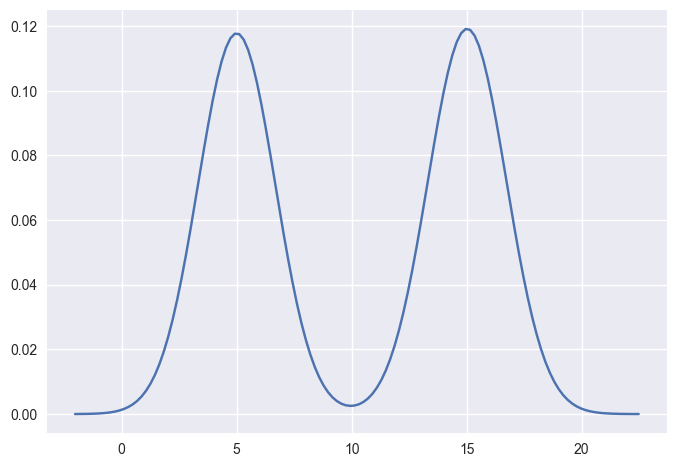

In [10]:
sns.kdeplot(x);

## Evidence Low Bound

$$\left.\begin{aligned} \operatorname { ELBO } \left( \mathbf { m } , s ^ { 2 } , \varphi \right) = & \sum _ { k = 1 } ^ { K } \mathbb { E } \left[ \log p \left( \mu _ { k } \right) ; m _ { k } , s _ { k } ^ { 2 } \right] \\ & + \sum _ { i = 1 } ^ { n } \left( \mathbb { E } \left[ \log p \left( c _ { i } \right) ; \varphi _ { i } \right] + \mathbb { E } \left[ \log p \left( x _ { i } | c _ { i } , \mu \right) ; \varphi _ { i } , m , s ^ { 2 } \right] \right) \\ & - \sum _ { i = 1 } ^ { n } \mathbb { E } \left[ \log q \left( c _ { i } ; \varphi _ { i } \right) \right] - \sum _ { k = 1 } ^ { K } \mathbb { E } \left[ \log q \left( \mu _ { k } ; m _ { k } , s _ { k } ^ { 2 } \right) \right] \end{aligned} \right.$$

Note that

$$\begin{aligned}
\mathbb { E } \left[ \log p \left( \mu _ { k } \right) ; m _ { k } , s _ { k } ^ { 2 } \right] &= - \frac{1}{2\sigma^2} (m_k^2 + s_k^2) + \mathrm{const} \\
\mathbb { E } \left[ \log p \left( c _ { i } \right) ; \varphi _ { i } \right] &= -\log K \\
\mathbb { E } \left[ \log p \left( x _ { i } | c _ { i } , \mu \right) ; \varphi _ { i } , m , s ^ { 2 } \right] &= \sum_{k=1}^K \varphi_{ik} \left(m_k x_i - \frac{m_k^2 + s_k^2}{2}\right) + \mathrm{const} \\
\mathbb { E } \left[ \log q \left( c _ { i } ; \varphi _ { i } \right) \right] &= \sum_{k=1}^K \varphi_{ik} \log \varphi_{ik} \\
 \mathbb { E } \left[ \log q \left( \mu _ { k } ; m _ { k } , s _ { k } ^ { 2 } \right) \right] &= \log s_k + \mathrm{const}
\end{aligned}$$

Thus we get,

\begin{aligned}\sum _ { k = 1 } ^ { K } \mathbb { E } \left[ \log p \left( \mu _ { k } \right) ; m _ { k } , s _ { k } ^ { 2 } \right] &= - \frac{1}{2\sigma^2} \sum_{k=1}^K (m_k^2 + s_k^2) + \mathrm{const} \\ \sum _ { i = 1 } ^ { n } \left( \mathbb { E } \left[ \log p \left( c _ { i } \right) ; \varphi _ { i } \right] + \mathbb { E } \left[ \log p \left( x _ { i } | c _ { i } , \mu \right) ; \varphi _ { i } , m , s ^ { 2 } \right] \right) &= \sum_{i=1}^{n} \sum_{k=1}^K \varphi_{ik} m_k x_i - \sum_{i=1}^{n} \sum_{k=1}^K \frac{m_k^2 + s_k^2}{2} + \mathrm{const}\\ -\sum _ { i = 1 } ^ { n } \mathbb { E } \left[ \log q \left( c _ { i } ; \varphi _ { i } \right) \right] &= -\sum_{i=1}^n \sum_{k=1}^K \varphi_{ik} \log \varphi_{ik} \\ - \sum _ { k = 1 } ^ { K } \mathbb { E } \left[ \log q \left( \mu _ { k } ; m _ { k } , s _ { k } ^ { 2 } \right) \right] &= -\sum_{k=1}\log s_k\end{aligned}

The implementation of ELBO

In [6]:
function ELBO(m::Vector{T}, s::Vector{T}, φ::Matrix{T}, x::Vector{T}, σ2=1.0) where T <: Float64
    """
    m (K)
    s (K)
    φ (n x K)
    x (n)
    """
    ms = (m.^2 + s.^2) / 2
    term1 = - sum(ms) / σ2
    term2 = x' * φ * m - sum(φ * ms)
    term3 = - sum(φ .* log.(φ))
    term4 = - sum(log.(s))
    #@show term1, term2, term3, term4
    term1 + term2 + term3 + term4
end

ELBO (generic function with 2 methods)

In [7]:
n = 1000
K = 2
x = rand(gmm, n);

In [8]:
c1 = map(t-> t < 10. ? 0.99 : 0.01, x)
c2 = 1.0 .- c1
φ = hcat(c1, c2);

In [9]:
m = [5.0, 13.0]
s = [1.0, 1.0]
ELBO(m, s, φ, x)

61481.21014710346

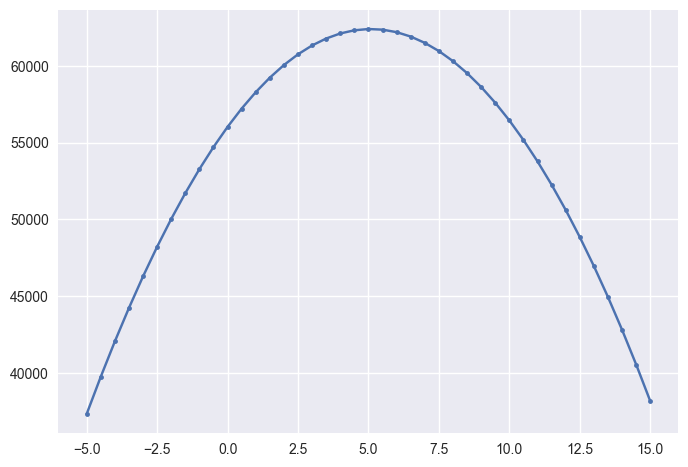

In [11]:
m1 = -5:0.5:15
elbo = map(a -> ELBO([a, 15.], s, φ, x), m1);
plot(m1, elbo, ".-");

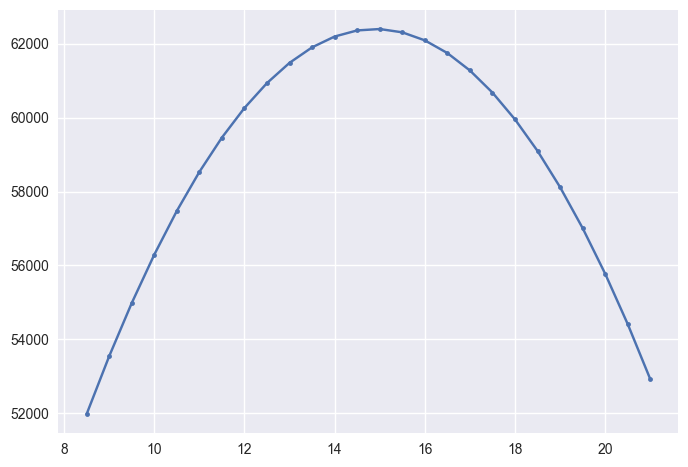

In [12]:
m2 = 8.5:0.5:21
elbo = map(a -> ELBO([5.0, a], s, φ, x), m2)
plot(m2, elbo, ".-");